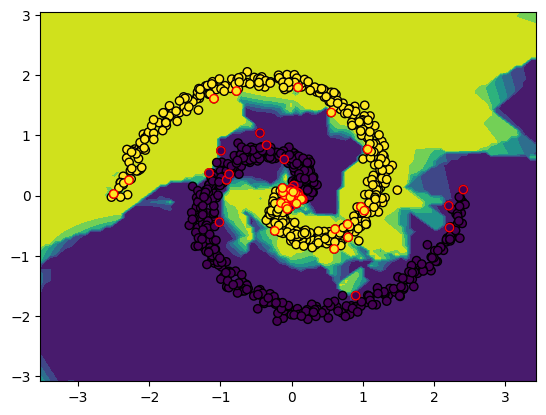

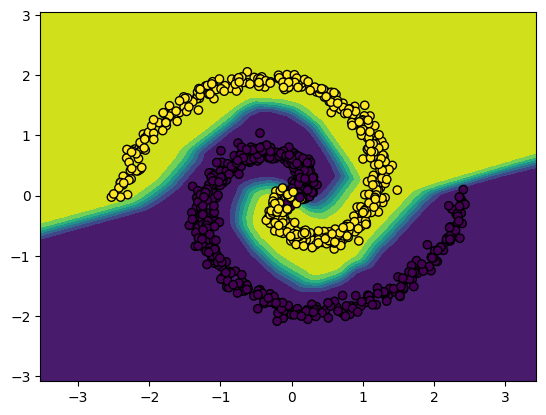

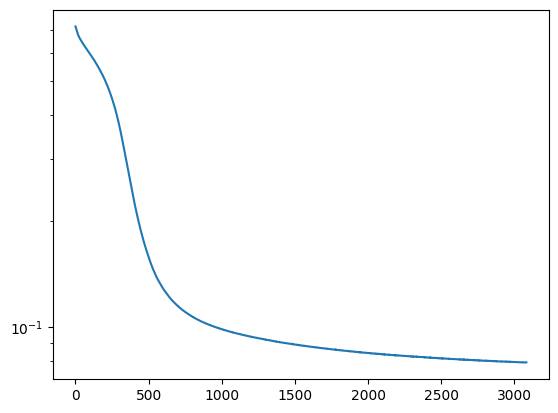

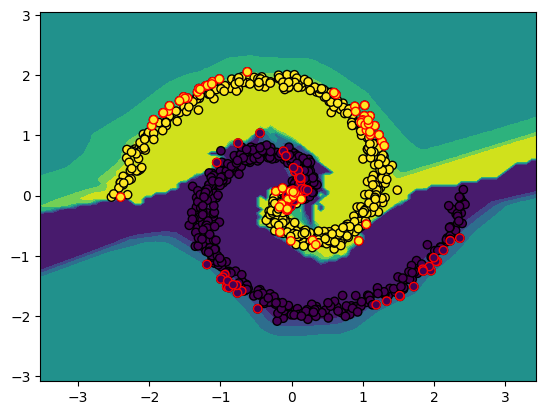

In [1]:
from functools import partial
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from mislabeled.probe._mlp import init_mlp, ntk
from mislabeled.datasets.toy import spirals
import numpy as np
import matplotlib.pyplot as plt

mlp = MLPClassifier(
    hidden_layer_sizes=[20, 20, 20],
    tol=1e-6,
    max_iter=10000,
    random_state=1,
    solver="sgd",
    alpha=0.2,
)

X, y = spirals(1000, random_state=1, spread=0.2, n_rotations=1)
X = StandardScaler().fit_transform(X)

mlp_ntk = init_mlp(mlp, X, y)

display = DecisionBoundaryDisplay.from_estimator(
    (svm := SVC(C=1e4, kernel=partial(ntk, mlp_ntk), probability=True)).fit(X, y),
    X,
    response_method="predict_proba",
)
display.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolor="black")
display.ax_.scatter(
    X[svm.support_, 0], X[svm.support_, 1], c=y[svm.support_], edgecolor="red"
)
display = DecisionBoundaryDisplay.from_estimator(
    mlp.fit(X, y),
    X,
    response_method="predict_proba",
)
display.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolor="black")
plt.show()
plt.plot(mlp.loss_curve_)
plt.yscale("log")
plt.show()
display = DecisionBoundaryDisplay.from_estimator(
    (
        svm := SVC(
            C=1e4,
            kernel=partial(ntk, mlp),
            probability=True,
        ).fit(X, y)
    ),
    X,
    response_method="predict_proba",
)
display.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolor="black")
display.ax_.scatter(
    X[svm.support_, 0], X[svm.support_, 1], c=y[svm.support_], edgecolor="red"
)

1202.171733833839 302.0378678927231


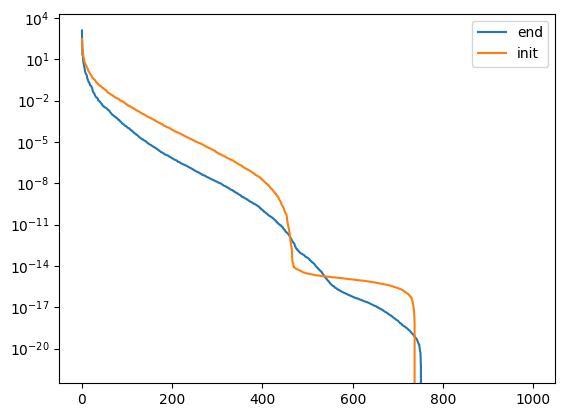

In [2]:
import matplotlib.pyplot as plt

K = ntk(mlp, X)
K_init = ntk(mlp_ntk, X)
print(np.linalg.norm(K, ord="fro"), np.linalg.norm(K_init, ord="fro"))

plt.plot(np.linalg.eigvalsh(K)[::-1], label="end")
plt.plot(np.linalg.eigvalsh(K_init)[::-1], label="init")
plt.legend()
plt.yscale("log")
plt.show()

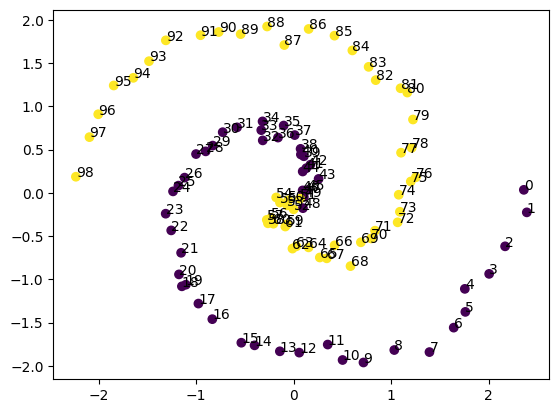

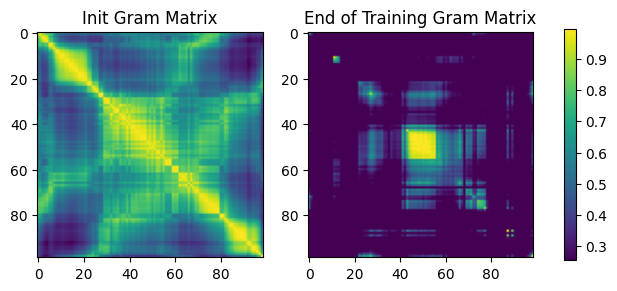

In [4]:
X, y = spirals(100, random_state=1, spread=0.2, n_rotations=1, shuffle=False)
X = StandardScaler().fit_transform(X)
X = np.concatenate([X[0:-1:2, :][::-1], X[1:-1:2, :]])
y = np.concatenate([y[0:-1:2][::-1], y[1:-1:2]])
K = ntk(mlp, X)
K_init = ntk(mlp_ntk, X)

plt.scatter(X[:, 0], X[:, 1], c=y)
for i, txt in enumerate(range(X.shape[0])):
    plt.annotate(txt, (X[i, 0], X[i, 1]))
plt.show()


def normalize(K):
    Kxx = np.diag(K) + np.diag(K).mean() / 100
    return K / np.sqrt(Kxx)[:, None] / np.sqrt(Kxx)[None, :]


fig, axes = plt.subplots(1, 2, figsize=(8, 6))
im = axes[0].imshow(normalize(K_init))
axes[0].set_title("Init Gram Matrix")
clim = im.properties()["clim"]
axes[1].imshow(normalize(K), clim=clim)
axes[1].set_title("End of Training Gram Matrix")
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
plt.show()

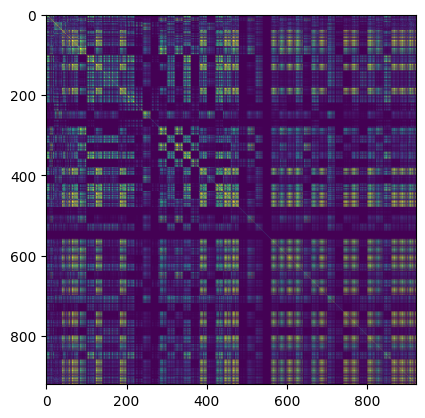

In [ ]:
from mislabeled.probe._mlp import linearize_mlp_fisher, linearize_mlp_last_layer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import  StandardScaler
from mislabeled.datasets.toy import spirals
import matplotlib.pyplot as plt
import numpy as np

def normalize(K):
    Kxx = np.diag(K) + np.diag(K).mean() / 100
    return K / np.sqrt(Kxx)[:, None] / np.sqrt(Kxx)[None, :]


X, y = spirals(1000, random_state=1, spread=0.2, n_rotations=1)
X = StandardScaler().fit_transform(X)

mlp = mlp = MLPClassifier(
    hidden_layer_sizes=[20, 20, 20],
    tol=1e-6,
    max_iter=10000,
    random_state=1,
    solver="sgd",
    alpha=0.2,
)


mlp.fit(X, y)
mlplin, Xl, yl = linearize_mlp_fisher(mlp, X, y)
plt.imshow(np.abs(normalize(mlplin.hessian(Xl, yl))))
plt.show()
mlplin, Xl, yl = linearize_mlp_last_layer(mlp, X, y)
plt.imshow(np.abs(normalize(mlplin.hessian(Xl, yl))))
plt.show()
